# NYC Home Ownership vs. Rental Cost Comparison

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import ticker

from nyc_home_cost_calculator.home import FilingStatus, NYCHomeCostCalculator
from nyc_home_cost_calculator.rent import NYCRentalCostCalculator

In [42]:
import warnings

warnings.filterwarnings("error")

In [43]:
# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

In [44]:
# Set random seed for reproducibility
rng = np.random.default_rng(1337)

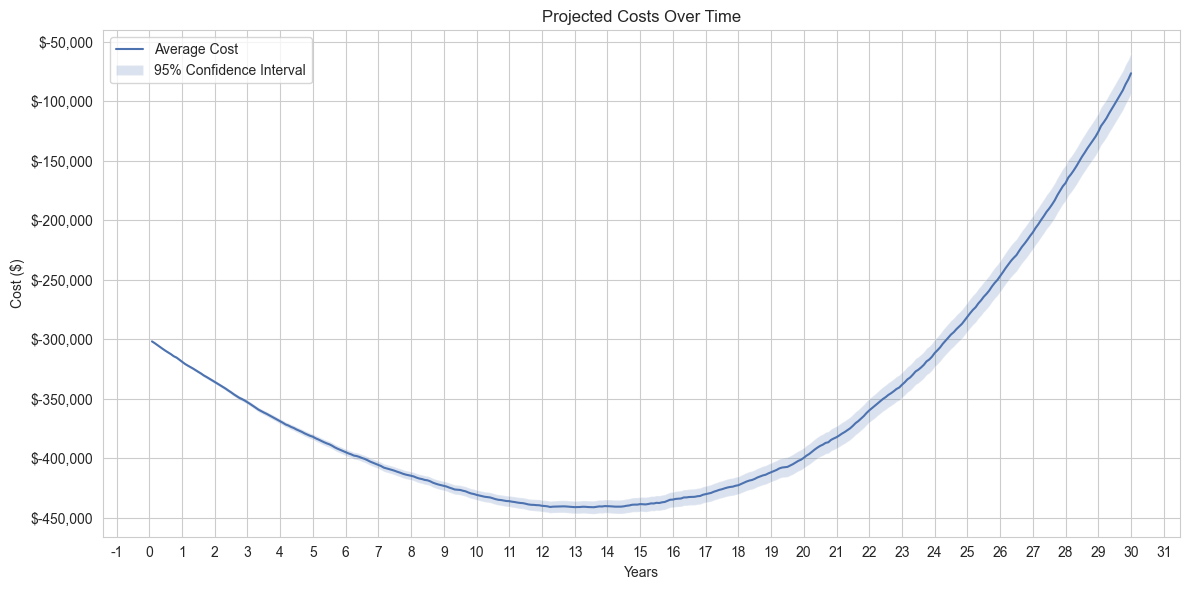

In [45]:
# Initialize calculators with default parameters
home_price = 1_000_000.0
down_payment = home_price * 0.20

home_calculator = NYCHomeCostCalculator(
    home_price=home_price,
    down_payment=down_payment,
    mortgage_rate=0.05,
    loan_term=30,
    initial_income=200_000.0,
    hoa_fee=500.0,
    insurance_rate=0.005,
    maintenance_rate=0.01,
    property_tax_rate=0.01,
    mean_appreciation_rate=0.03,
    appreciation_volatility=0.05,
    mean_inflation_rate=0.02,
    inflation_volatility=0.01,
    mean_income_change_rate=0.02,
    income_change_volatility=0.03,
    retirement_contribution_rate=0.15,
    filing_status=FilingStatus.SINGLE,
    extra_payment=0.0,
    extra_payment_start_year=1,
    extra_payment_end_year=30,
    purchase_closing_cost_rate=0.03,
    sale_closing_cost_rate=0.07,
    simulations=1_000,
    rng=rng,
)

# Run simulation
monthly_home_costs, cumulative_home_costs, extra_home = home_calculator.simulate_costs_over_time()

# Plot the results
home_calculator.plot_costs_over_time(cumulative_home_costs)

# Save the results to an Excel spreadsheet
home_calculator.export_to_excel("home-costs.xlsx", cumulative_home_costs)

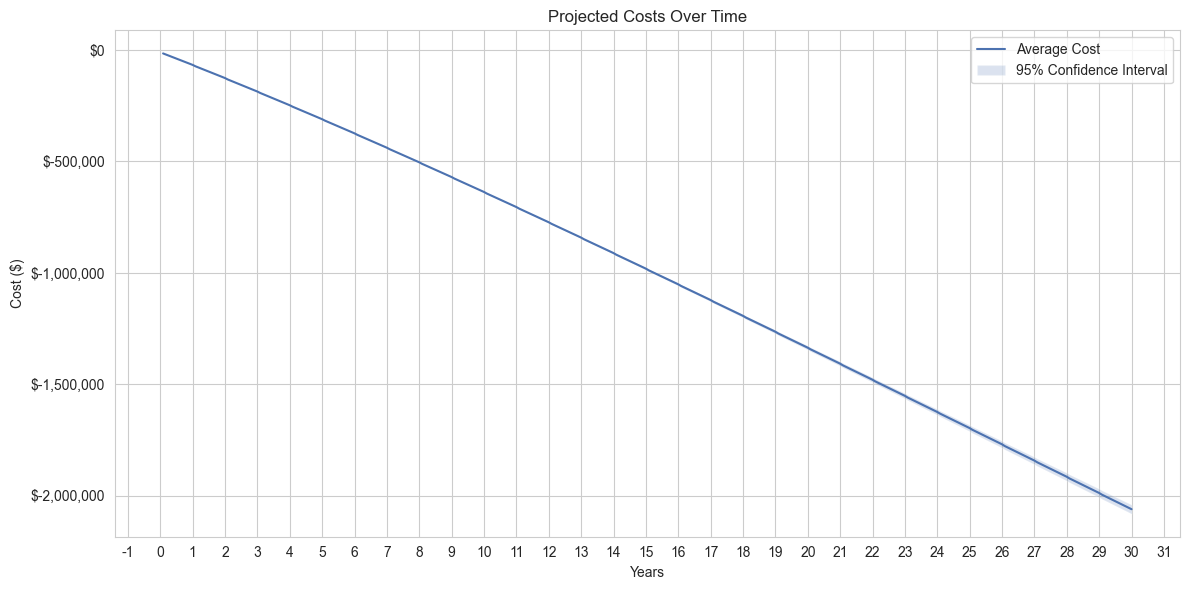

In [46]:
rental_calculator = NYCRentalCostCalculator(
    initial_rent=4_500.0,
    lease_term=1.0,
    total_years=30,  # Match the home ownership term
    utility_cost=100.0,
    renters_insurance=300.0,
    moving_cost=2_500.0,
    mean_rent_increase_rate=0.03,
    rent_increase_volatility=0.01,
    mean_inflation_rate=0.02,
    inflation_volatility=0.01,
    broker_fee_rate=0.15,
    move_probability=0.1,
    rent_increase_move_threshold=0.1,
    simulations=1_000,
    rng=rng,
)

# Run simulation
monthly_rental_costs, cumulative_rental_costs, extra_rent = rental_calculator.simulate_costs_over_time()

# Plot the results
rental_calculator.plot_costs_over_time(cumulative_rental_costs)

# Save the results to an Excel spreadsheet
rental_calculator.export_to_excel("rental-costs.xlsx", cumulative_rental_costs)

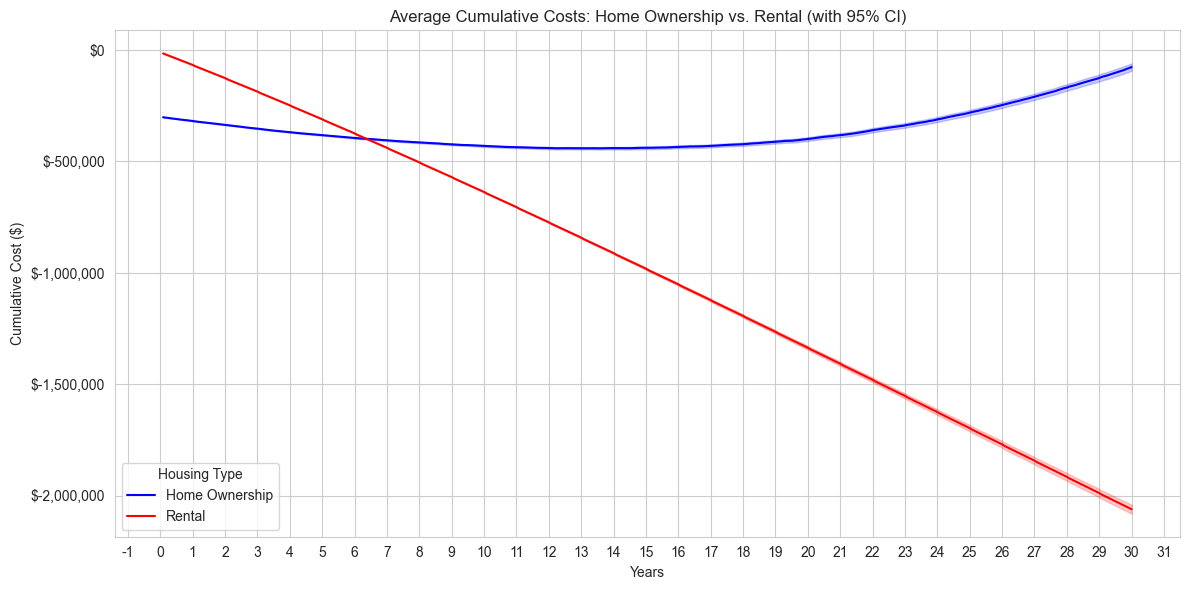

In [47]:
# Prepare data for plotting
years = np.array(list(range(1, (12 * 30) + 1))) / 12


# Calculate confidence intervals
def calculate_ci(costs):
    # Calculate mean and standard error for each year
    means = np.mean(costs, axis=1)
    std_errors = np.std(costs, axis=1) / np.sqrt(costs.shape[1])

    # Calculate 95% confidence intervals
    ci_lower = means - 1.96 * std_errors
    ci_upper = means + 1.96 * std_errors

    return means, ci_lower, ci_upper


# Calculate statistics for home ownership and rental
home_means, home_ci_lower, home_ci_upper = calculate_ci(cumulative_home_costs)
rental_means, rental_ci_lower, rental_ci_upper = calculate_ci(cumulative_rental_costs)

# Plot average costs over time with confidence intervals
plt.figure(figsize=(12, 6))

# Plot home ownership data
plt.plot(years, home_means, label="Home Ownership", color="blue")
plt.fill_between(years, home_ci_lower, home_ci_upper, alpha=0.2, color="blue")

# Plot rental data
plt.plot(years, rental_means, label="Rental", color="red")
plt.fill_between(years, rental_ci_lower, rental_ci_upper, alpha=0.2, color="red")

plt.title("Average Cumulative Costs: Home Ownership vs. Rental (with 95% CI)")
plt.xlabel("Years")
plt.ylabel("Cumulative Cost ($)")
plt.legend(title="Housing Type")

# Format axes
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

plt.tight_layout()
plt.show()

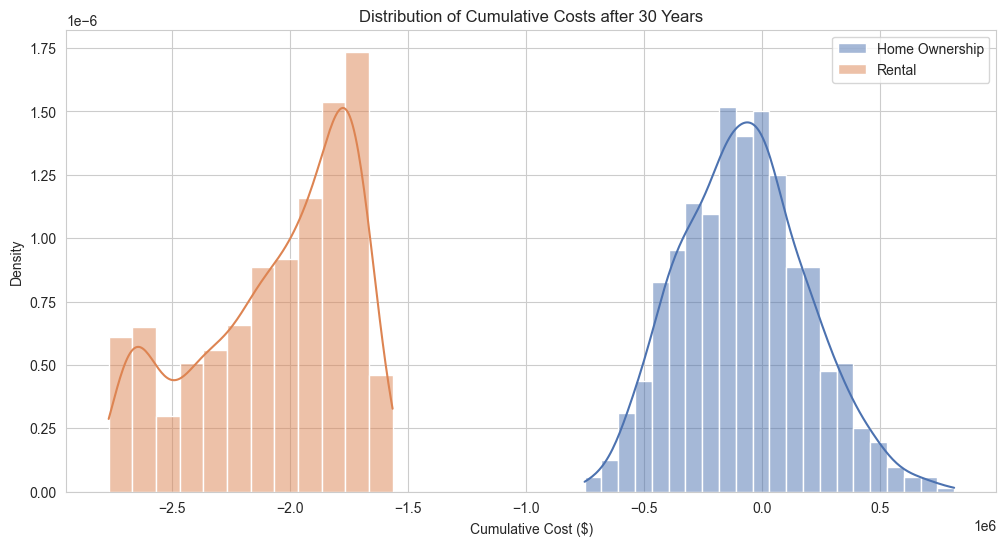

In [48]:
# Calculate and plot cost distribution for the final month
home_final_month = cumulative_home_costs[-1]
rental_final_month = cumulative_rental_costs[-1]

plt.figure(figsize=(12, 6))
sns.histplot(home_final_month, kde=True, stat="density", label="Home Ownership")
sns.histplot(rental_final_month, kde=True, stat="density", label="Rental")
plt.title("Distribution of Cumulative Costs after 30 Years")
plt.xlabel("Cumulative Cost ($)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [49]:
# Calculate and print summary statistics
home_stats = home_calculator.get_cost_statistics(cumulative_home_costs)
rental_stats = rental_calculator.get_cost_statistics(cumulative_rental_costs)

print("Home Ownership Statistics:")
for stat, value in home_stats.items():
    print(f"{stat.capitalize()}: ${value:,.2f}")

print("\nRental Statistics:")
for stat, value in rental_stats.items():
    print(f"{stat.capitalize()}: ${value:,.2f}")

Home Ownership Statistics:
Mean: $-76,270.21
Median: $-80,354.18
Std_dev: $268,886.82
Percentile_5: $-507,269.22
Percentile_95: $376,757.88

Rental Statistics:
Mean: $-2,060,612.73
Median: $-1,976,952.86
Std_dev: $325,223.78
Percentile_5: $-2,679,014.62
Percentile_95: $-1,675,429.16


In [50]:
msg = "Based on the given parameters and simulations, "
if home_stats["mean"] > rental_stats["mean"]:
    msg += "homeownership appears to be more cost-effective in the long run.\n"
else:
    msg += "renting appears to be more cost-effective in the long run.\n"
msg += "However, this conclusion is highly dependent on the input parameters and individual circumstances.\n"
print(msg)

Based on the given parameters and simulations, homeownership appears to be more cost-effective in the long run.
However, this conclusion is highly dependent on the input parameters and individual circumstances.

